In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support

In [36]:
LABEL_COL = 'ICD9'

df_TFIDF40 = pd.read_csv('input_ICD9_TFIDF_40.csv')
df_TFIDF40.rename(columns={'Label': LABEL_COL}, inplace=True)
df_TM5 = pd.read_csv('input_ICD9_TM_5.csv')
df_TM20 = pd.read_csv('input_ICD9_TM_20.csv')
df_TM30 = pd.read_csv('input_ICD9_TM_30.csv')
df_TM30.rename(columns={'top_icd': LABEL_COL}, inplace=True)

df_list = [df_TFIDF40, df_TM5, df_TM20, df_TM30]
files_list = ['TFIDF_40', 'TM_5', 'TM_20', 'TM_30']

In [68]:
# Some data quality checks that Label is consistent
print([True for df in df_list if LABEL_COL in df.columns])
print([df.shape for df in df_list])
print([df[LABEL_COL].value_counts() for df in df_list])

[True, True, True, True]
[(11537, 41), (11537, 6), (11537, 21), (11537, 31)]
[414    3502
38     3184
410    3175
424    1676
Name: ICD9, dtype: int64, 414    3502
38     3184
410    3175
424    1676
Name: ICD9, dtype: int64, 414    3502
38     3184
410    3175
424    1676
Name: ICD9, dtype: int64, 414    3502
38     3184
410    3175
424    1676
Name: ICD9, dtype: int64]


In [60]:
def get_classification_metrics_rf(df: pd.DataFrame, label_col:str):
    '''
    Get metrics from Random Forest Model
    Args:
        df: pandas DataFrame
        label_col: column name of the label
    Returns: results dictionary with performance metrics, predicted results, and random forest model
    '''
    # Train test split
    X = df.drop(columns=[label_col])
    y = df[label_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Random Forest Classifer
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_prob = rf.predict_proba(X_test)
    
    rf_acc = accuracy_score(y_test, rf_pred)
    rf_bal_acc = balanced_accuracy_score(y_test, rf_pred)
    rf_precision = precision_score(y_test, rf_pred, average = 'macro')
    rf_recall = recall_score(y_test, rf_pred, average = 'macro')
    rf_f1_weighted = f1_score(y_test, rf_pred, average = 'weighted')
    rf_f1_avg = f1_score(y_test, rf_pred, average = 'macro')
    rf_auc = roc_auc_score(y_test, rf_prob, multi_class='ovr', average='macro')
    
    # Construct results
    results = dict()
    results['pred'], results['pred_prob'] = rf_pred, rf_prob
    results['acc'] = rf_acc
    results['bal_acc'] = rf_bal_acc
    results['precision'] = rf_precision
    results['recall'] = rf_recall
    results['f1_weighted'] = rf_f1_weighted
    results['f1_avg'] = rf_f1_avg
    results['auc'] = rf_auc
    results['model'] = rf
        
    return results

In [61]:
rf_results_list = [get_classification_metrics_rf(df, LABEL_COL) for df in df_list]

In [51]:
def get_classification_metrics_km(filepath: str, label_col:str):
    '''
    Get metrics from K means model (iterating matching cluster labels with actual labels until best accuracy is returned)
    Args:
        filepath: filepath of csv 
        label_col: name of label column
    Returns: results dictionary with performance metrics
    '''
    d = pd.read_csv(filepath)
    d.rename(columns={'Label': label_col}, inplace=True)
    d.rename(columns={'top_icd': label_col}, inplace=True)
    ICD9_CODE_map = {
        424:  0,
        414:  1,
        410: 2,
        38: 3,
    }

    d[label_col] = d[label_col].map(ICD9_CODE_map)

    X = d.drop(columns=[label_col])
    kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

    pred = kmeans.labels_
    true = d[label_col].values

    acc=0
    max = 0
    predTemp=[-1,-1,-1,-1]
    predNew=[-1]*len(pred)
    predAssign = pd.Series(pred)
    predFinal=[-1]*len(pred)


    for i in range(4):
        predTemp[i]=0
        for j in range(4):
            if j!=i:
                predTemp[j]=1
            else:
                continue
            for k in range(4):
                if k!=i and k!=j:
                    predTemp[k]=2
                else:
                    continue
                for l in range(4):
                    if l!=i and l!=k and l!=j:
                        predTemp[l]=3
                        pred_map = {
                            0: predTemp[0],
                            1: predTemp[1],
                            2: predTemp[2],
                            3: predTemp[3],
                        }
                        predNew = predAssign.map(pred_map)
                        predNew = predNew.values
                        acc = accuracy_score(true, predNew)
                        if acc > max: 
                            max = acc
                            predFinal = predNew  
                    else:
                        continue
                        
    km_acc = accuracy_score(true, predFinal)
    km_bal_acc = balanced_accuracy_score(true, predFinal)
    km_precision = precision_score(true, predFinal, average = 'macro')
    km_recall = recall_score(true, predFinal, average = 'macro')
    km_f1_weighted = f1_score(true, predFinal, average = 'weighted')
    km_f1_avg = f1_score(true, predFinal, average = 'macro')
    
    # Construct results
    results = dict()
    results['acc'] = km_acc
    results['bal_acc'] = km_bal_acc
    results['precision'] = km_precision
    results['recall'] = km_recall
    results['f1_weighted'] = km_f1_weighted
    results['f1_avg'] = km_f1_avg
    
    return results

In [62]:
rf_results_list

[{'pred': array([ 38, 410, 410, ...,  38, 414, 414], dtype=int64),
  'pred_prob': array([[0.87, 0.04, 0.04, 0.05],
         [0.  , 0.99, 0.01, 0.  ],
         [0.02, 0.62, 0.3 , 0.06],
         ...,
         [0.95, 0.03, 0.02, 0.  ],
         [0.04, 0.31, 0.63, 0.02],
         [0.  , 0.05, 0.75, 0.2 ]]),
  'acc': 0.8186019641825535,
  'bal_acc': 0.8160590932587515,
  'precision': 0.8179226215183386,
  'recall': 0.8160590932587515,
  'f1_weighted': 0.8177652863629854,
  'f1_avg': 0.816752642365582,
  'auc': 0.9486689048009529,
  'model': RandomForestClassifier()},
 {'pred': array([ 38, 410, 414, ...,  38, 424, 414], dtype=int64),
  'pred_prob': array([[0.99, 0.  , 0.  , 0.01],
         [0.03, 0.72, 0.14, 0.11],
         [0.  , 0.03, 0.8 , 0.17],
         ...,
         [1.  , 0.  , 0.  , 0.  ],
         [0.03, 0.31, 0.17, 0.49],
         [0.  , 0.  , 0.71, 0.29]]),
  'acc': 0.658578856152513,
  'bal_acc': 0.6198788159013208,
  'precision': 0.6316144624403477,
  'recall': 0.61987881590132

In [55]:
filepath_list = ['input_ICD9_TFIDF_40.csv', 'input_ICD9_TM_5.csv', 'input_ICD9_TM_20.csv', 'input_ICD9_TM_30.csv']
km_results_list = [get_classification_metrics_km(filepath, LABEL_COL) for filepath in filepath_list]

In [56]:
km_results_list

[{'acc': 0.4916356071769091,
  'bal_acc': 0.48429794283721417,
  'precision': 0.4898849098984255,
  'recall': 0.48429794283721417,
  'f1_weighted': 0.4224975595925237,
  'f1_avg': 0.4364853059229689},
 {'acc': 0.5852474646788594,
  'bal_acc': 0.6165459730631955,
  'precision': 0.578042216487441,
  'recall': 0.6165459730631955,
  'f1_weighted': 0.5699828394879753,
  'f1_avg': 0.5677573355533626},
 {'acc': 0.5648782179076016,
  'bal_acc': 0.5016036192428992,
  'precision': 0.46870554822891114,
  'recall': 0.5016036192428992,
  'f1_weighted': 0.5365744005080538,
  'f1_avg': 0.4784618002873484},
 {'acc': 0.5779665424287076,
  'bal_acc': 0.5112029229540757,
  'precision': 0.5031251654668742,
  'recall': 0.5112029229540757,
  'f1_weighted': 0.5571966550938213,
  'f1_avg': 0.4971447497963916}]

In [75]:
# Feature importance
def get_feature_importance(df: pd.DataFrame, model: RandomForestClassifier(), label_col: str):    
    features = df.drop(columns=[label_col]).columns
    feature_importances = pd.DataFrame({'features': features, 'importance': model.feature_importances_})
    return feature_importances.sort_values(by='importance', ascending=False)

In [84]:
# Comparison of 20 Topic Model Feature Importance with RF
get_feature_importance(df_TM20, rf_results_list[2]['model'], LABEL_COL)

,features,importance
4,T4,0.129412
5,T5,0.103738
3,T3,0.080565
17,T17,0.075559
16,T16,0.073956
0,T0,0.065658
18,T18,0.058083
2,T2,0.057763
1,T1,0.043019
10,T10,0.041866


Text(0.5, 1.0, 'Label Distribution')

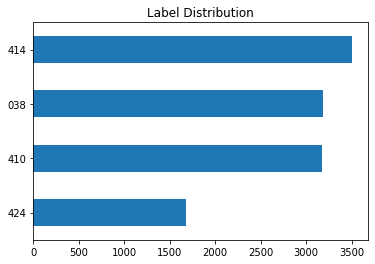

In [83]:
# label_distribution
df_TFIDF40_plot = df_TFIDF40[LABEL_COL].replace(38, "038")
df_TFIDF40_plot.value_counts().sort_values().plot(kind = 'barh').set_title("Label Distribution")